# 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime

from IPython.core.display import HTML
import matplotlib.pyplot as plt
from IPython.display import Image
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv',low_memory=False)
df_store_raw = pd.read_csv('data/store.csv',low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left',on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
414762,768,3,2014-06-25,9507,1117,1,0,0,0,a,c,2630.0,9.0,2012.0,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTIONS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data Dimensions 

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0]))
print( 'Number of Columns: {}'.format( df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
# competition_distance  
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month  
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                      
# promo2_since_week    
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year 
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval  
month_map = {1: 'Jan', 2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Set',10:'Oct',11:'Nov',12:'Dec'}    

df1['promo_interval'].fillna(0, inplace=True ) 

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0 , axis=1 )


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes( include=['int64' , 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64' , 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply( np.median)).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std)).T
d2 = pd.DataFrame( num_attributes.apply( min)).T
d3 = pd.DataFrame( num_attributes.apply( max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

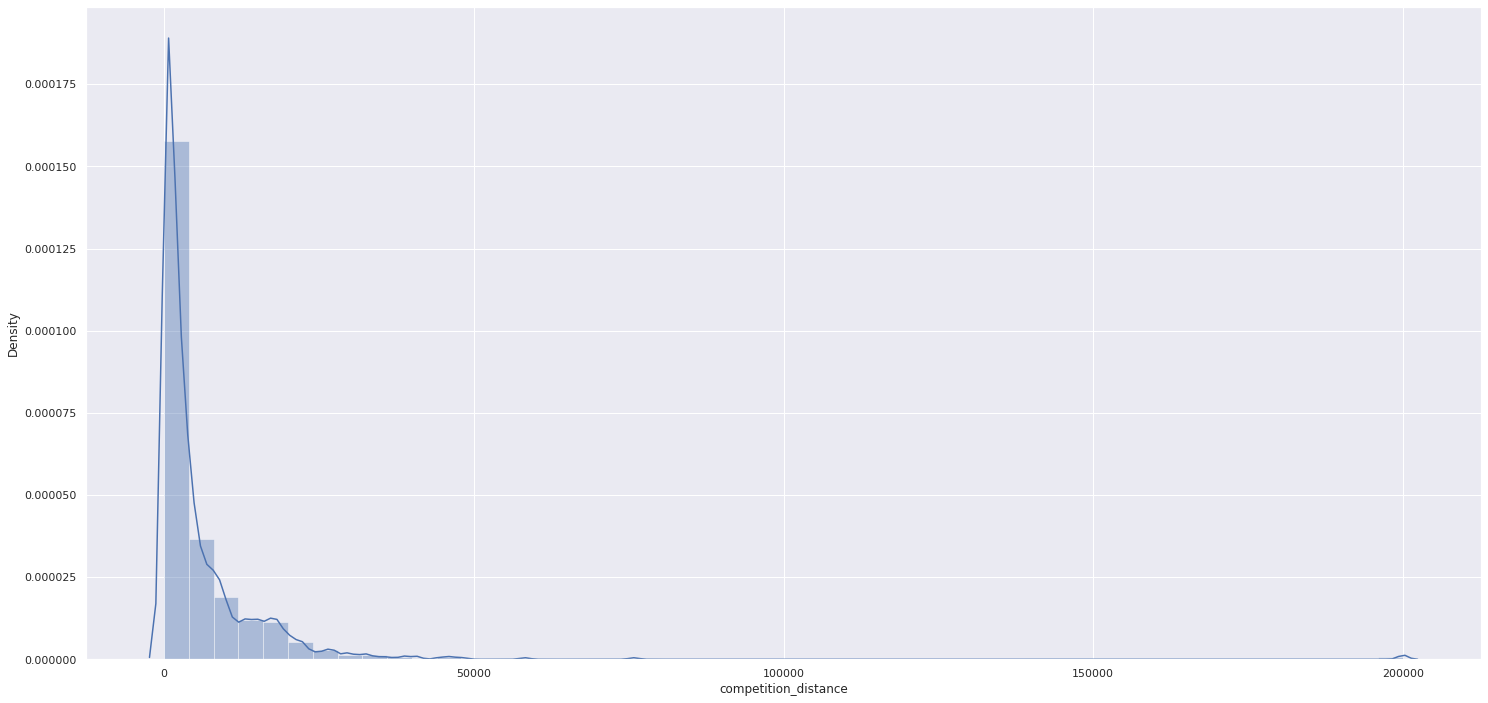

In [17]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

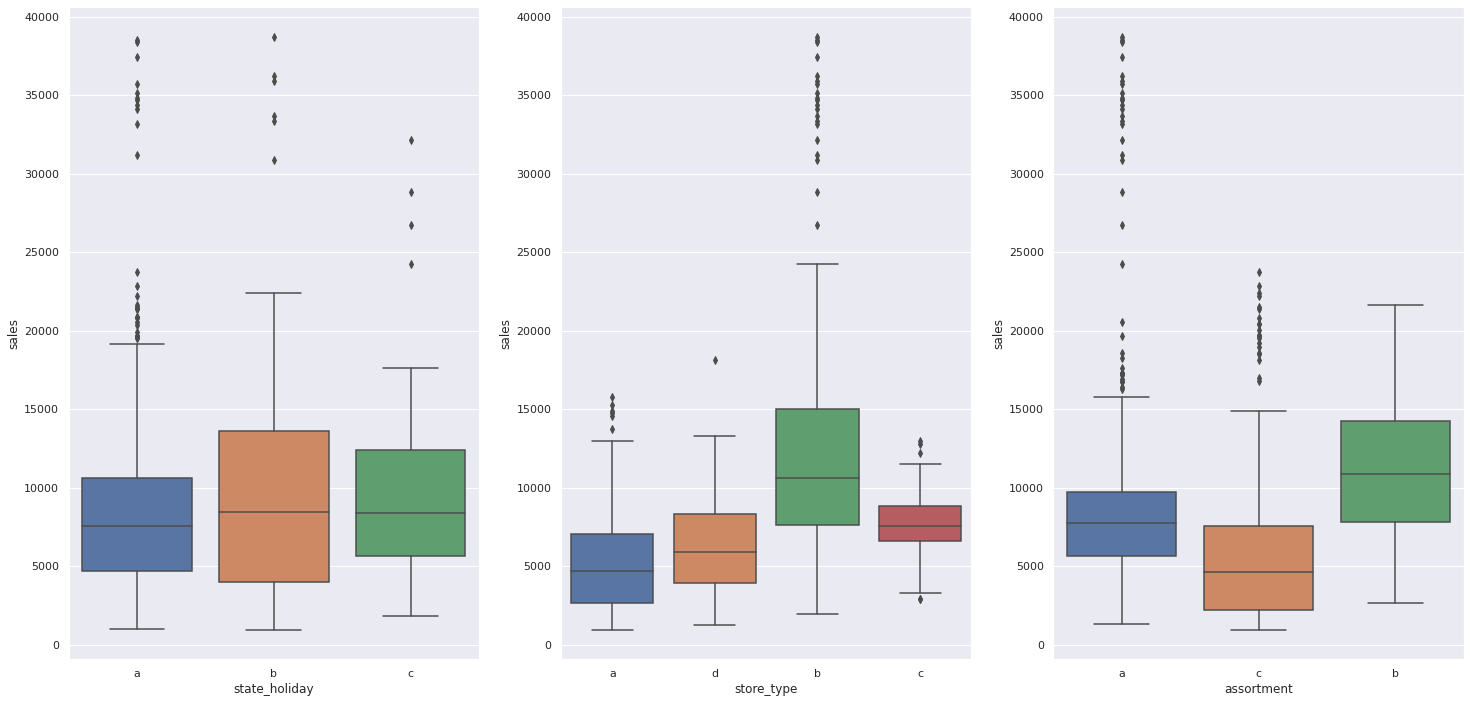

In [19]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1,3,1)
sns.boxplot(x='state_holiday' , y='sales' ,data=aux1 )

plt.subplot( 1,3,2)
sns.boxplot(x='store_type' , y='sales' ,data=aux1 )

plt.subplot( 1,3,3)
sns.boxplot(x='assortment' , y='sales' ,data=aux1 )

# 2.0 FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

## 2.1 Mind Map Hypothesis

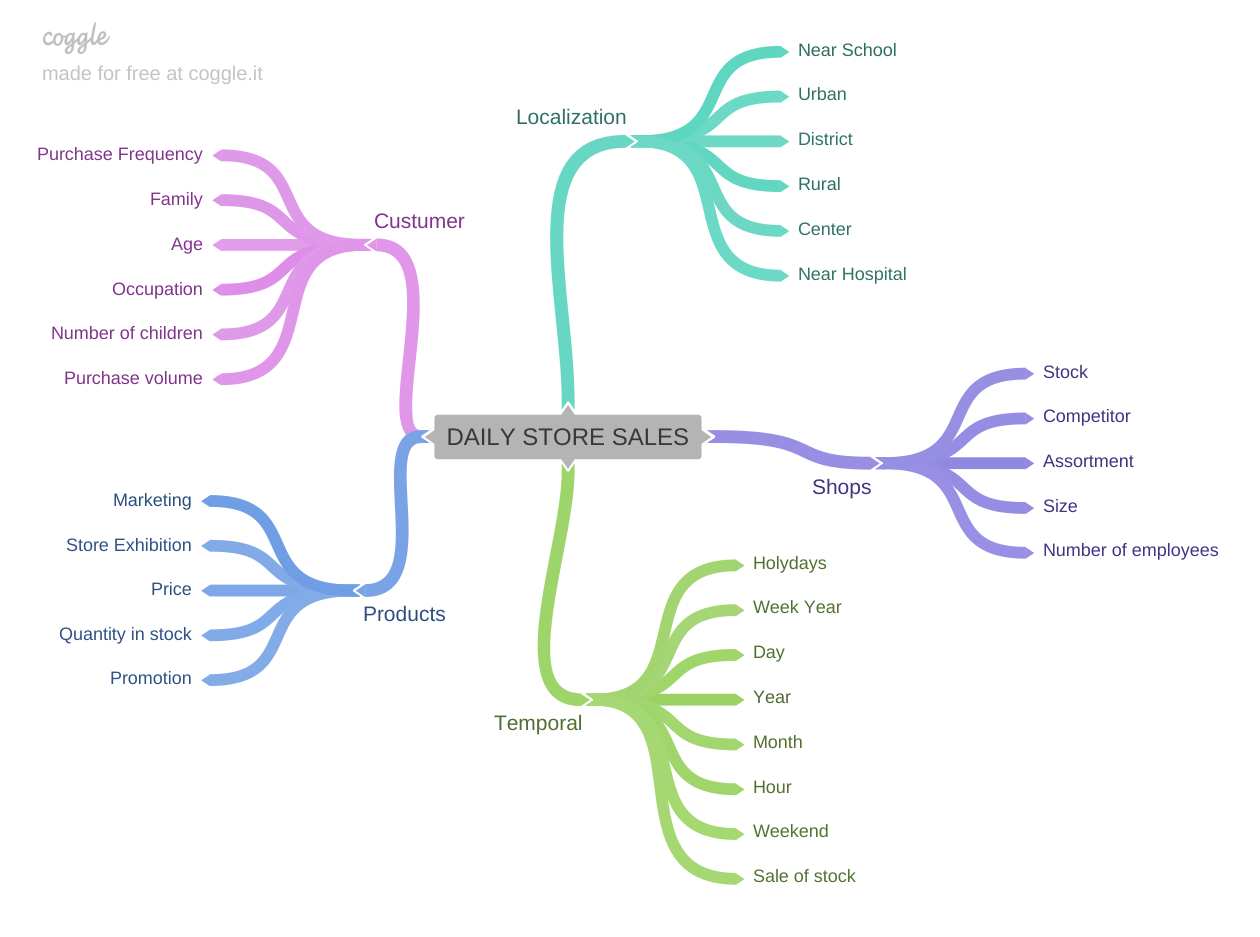

In [21]:
Image( 'img/mapmindhipothesis.png')

## 2.2 Hypothesis Creation

### 2.2.1 Shops Hypothesis

**1.** Stores with larger staff sell more

**2.** Stores with higher stock sell more

**3.** Larger stores should sell more

**4.** Stores with a larger assortment should sell more

**5.** Stores with closer competitors should sell less

**6.** Stores with competitors for longer should sell more

### 2.2.2 Products Hypothesis

**1.** Stores that invest more in Marketing should sell more

**2.** Stores that display more of the product in their windows should sell more

**3.** Stores that have lower product prices should sell more

**4.** Stores with more aggressive promotions (larger discounts) should sell more

**5.** Stores with promotions active for longer should sell more

**6.** Stores with more days of promotions should sell more

**7.** Stores with more than consecutive promotions should sell more

### 2.2.3 Temporal Hypothesis

**1.** Stores open during the Christmas holiday should sell more

**2.** Stores should sell more over the years

**3.** Stores should sell more in the second half of the year

**4.** Stores should sell more after the 10th of each month

**5.** Stores should sell less on weekends

**6.** Stores should sell less during school holidays

## 2.3 Final List of Hipothesis

**1.** Stores with a larger assortment should sell more

**2.** Stores with closer competitors should sell less

**3.** Stores with competitors for longer should sell more


**4.** Stores with promotions active for longer should sell more

**5.** Stores with more days of promotions should sell more

**6.** Stores with more than consecutive promotions should sell more


**7.** Stores open during the Christmas holiday should sell more

**8.** Stores should sell more over the years

**9.** Stores should sell more in the second half of the year

**10.** Stores should sell more after the 10th of each month

**11.** Stores should sell less on weekends

**12.** Stores should sell less during school holidays

## 2.4 Feature Engineering

In [22]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'] , 
                                                                   month=x['competition_open_since_month'], 
                                                                   day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply( lambda x: x.days).astype(int)

#promo since
df2['promo_since'] =  df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' 
                                                                             else 'easter_holiday' if x == 'b' 
                                                                             else 'christmas' if x == 'c'
                                                                             else 'regular_day')

In [23]:
df2.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
store,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
day_of_week,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822,5651,15344,8492,8565,7185,10457,8959,8821,6544,9191,10231,8430,10071,8234,9593
customers,555,625,821,1498,559,589,1414,833,687,681,1236,962,568,710,766,979,946,936,718,974
open,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
promo,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0
store_type,c,a,a,c,a,a,a,a,a,a,a,a,d,a,d,a,a,d,a,d


# 3.0 FILTERING OF VARIABLES


In [24]:
df3 = df2.copy()

In [25]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Rows FIltering

In [26]:
df3 = df3[(df3['open']!= 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [27]:
cols_drop = ['customers','open','promo_interval','month_map']

df3 = df3.drop( cols_drop, axis=1)

# 4.0 EDA - EXPLORATORY DATA ANALYSIS

In [28]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales'>

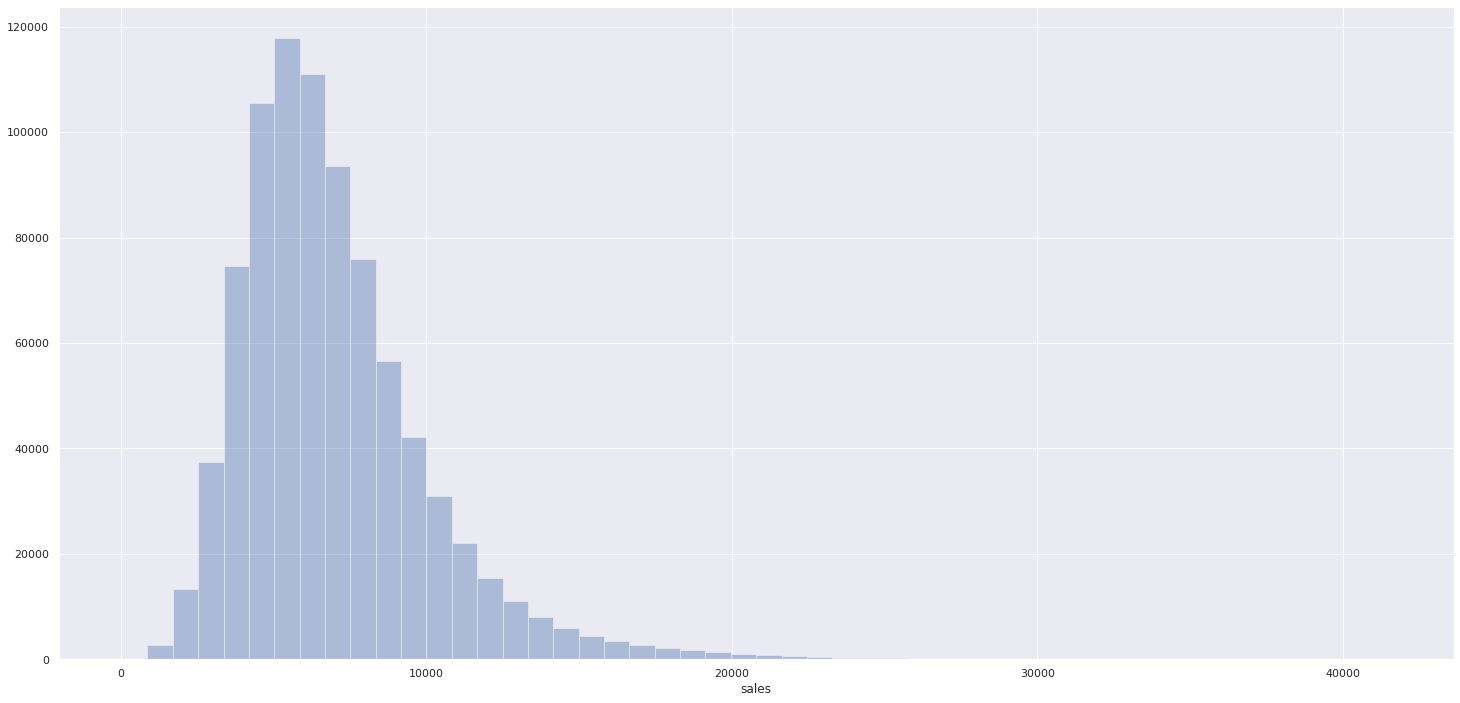

In [29]:
sns.distplot(df4['sales'],kde=False)

### 4.1.2 Numerical Variable

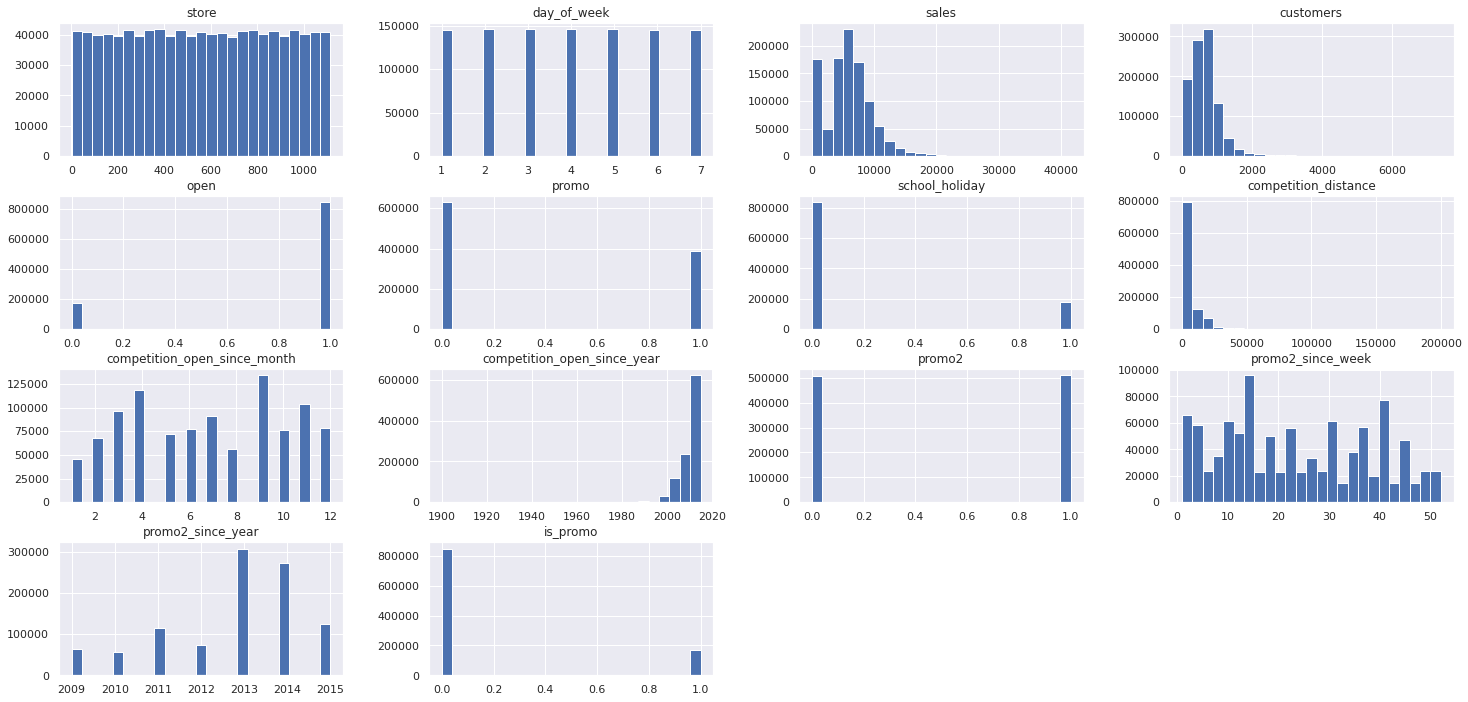

In [30]:
num_attributes.hist(bins=25);

In [31]:
# day_of_week:  O dia da semana interfere minimamente no volume de vendas
# customers: Há uma kurtosis e um skew positivo.A quantidade de customers não influencia proporcionalmente o volume de vendas
# promo: Há maior volume de vendas quando não há promo
# school_holiday: Volume de vendas é maior quando não há school holiday
# competition_distance: Há uma kurtosis e um skew positivo. Os competidores estão muito próximos
# competition_open_since_month: Há um comportamento de subida de decréscimo constante
# competition_open_since_year: Há uma kurtosis e um skew negativo.
# promo2: Volume de vendas praticamente igual entre os dois indicadores
# promo2_since_week: Há muitas variações ao longo das semanas
# promo2_since_year:  Houve um pico nos anos de 2013 e 2014
# is_promo: Volume de vendas maior quando não há promo

### 4.1.3 Categorical Variable

In [32]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

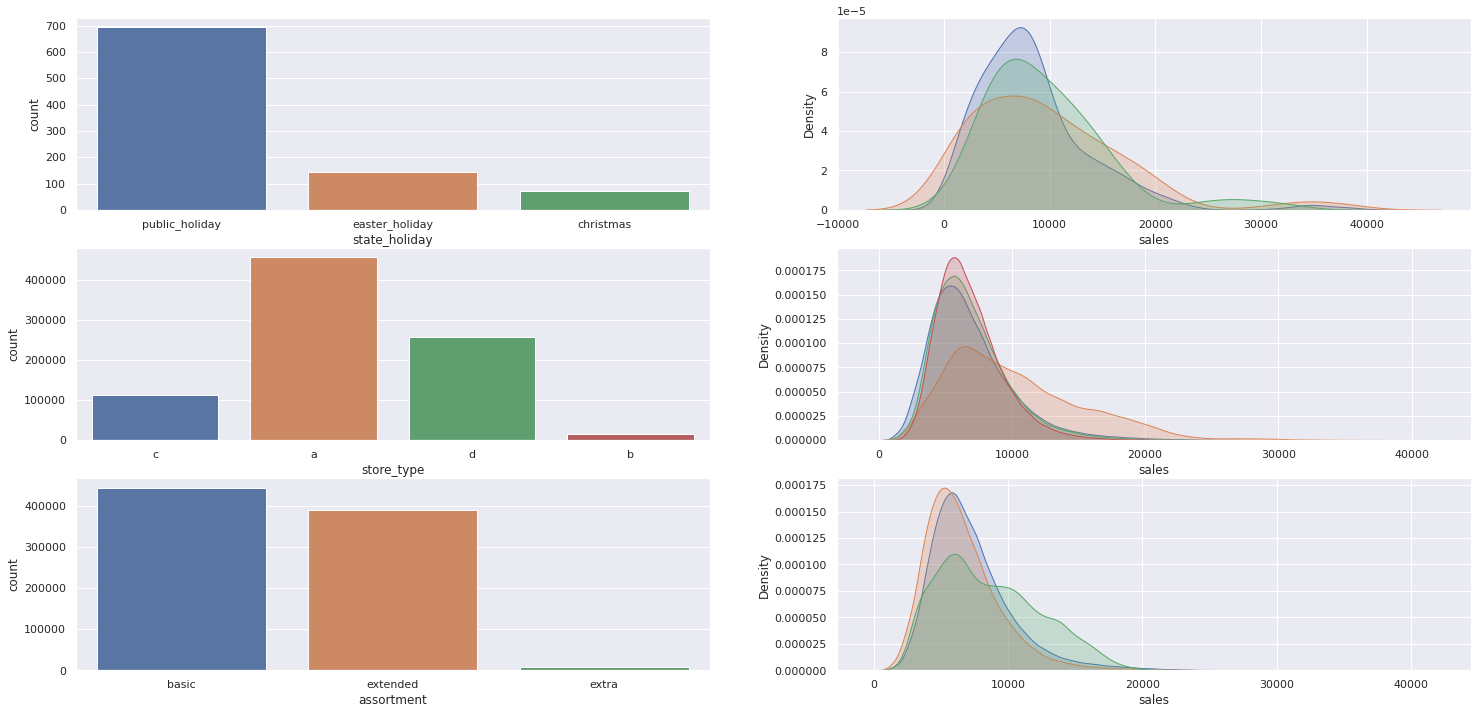

In [33]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',shade=True)

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a',shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b',shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c',shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d',shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True)


## 4.1 Bivariate Analysis

### H1. Stores with a larger assortment should sell more - FALSE

<AxesSubplot:xlabel='year_week'>

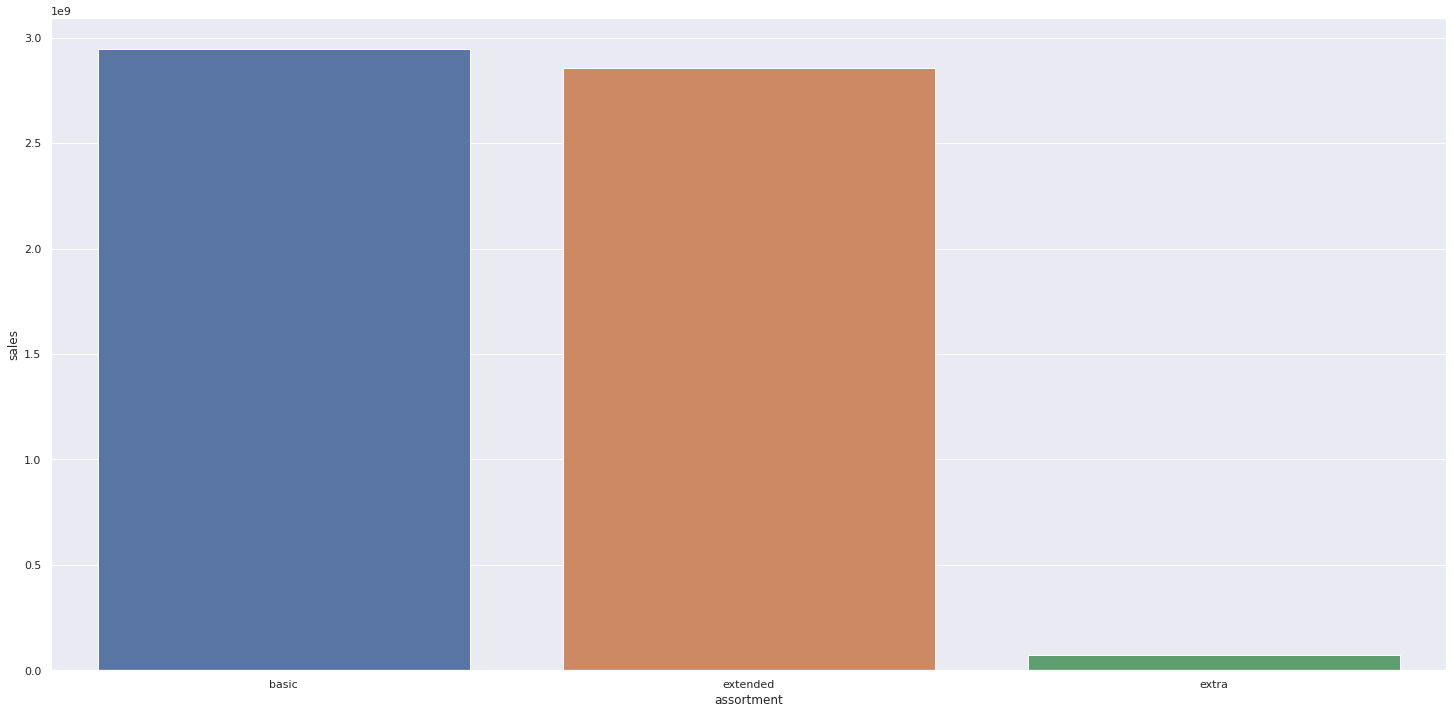

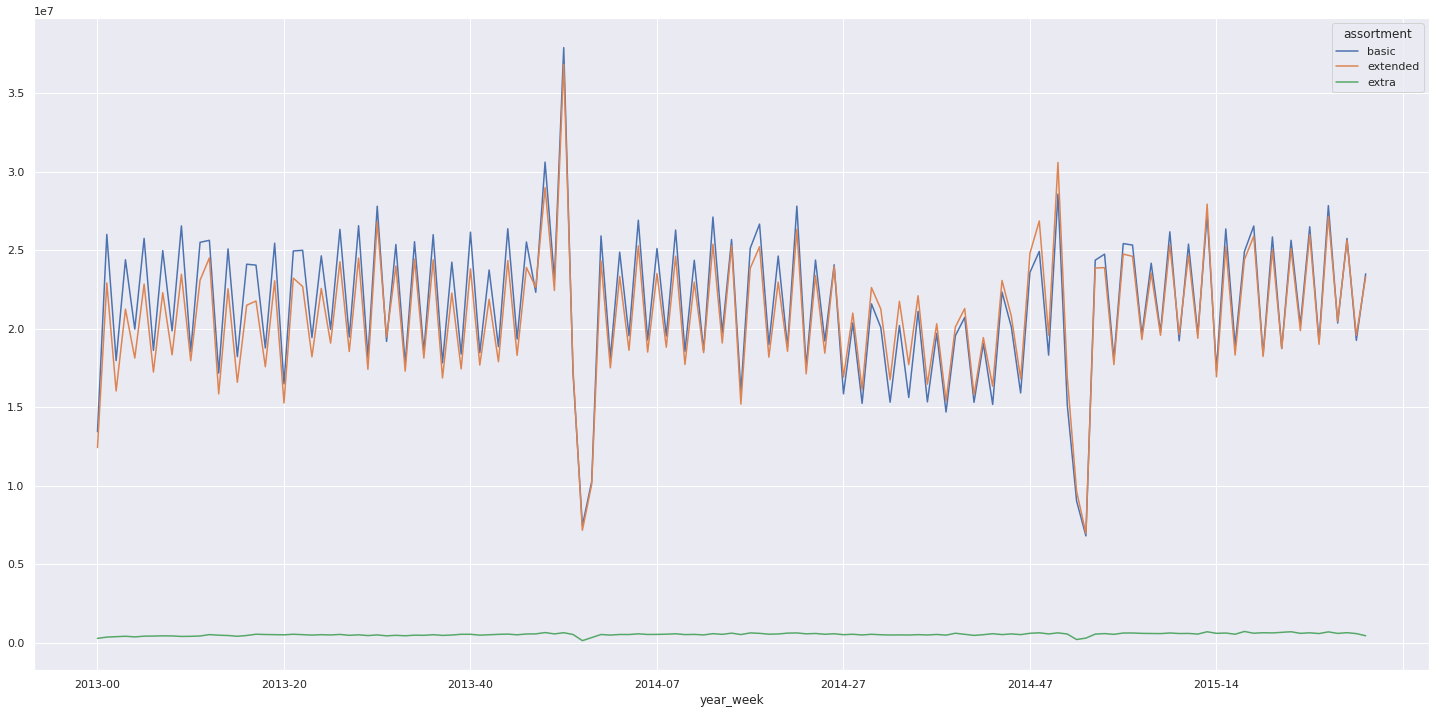

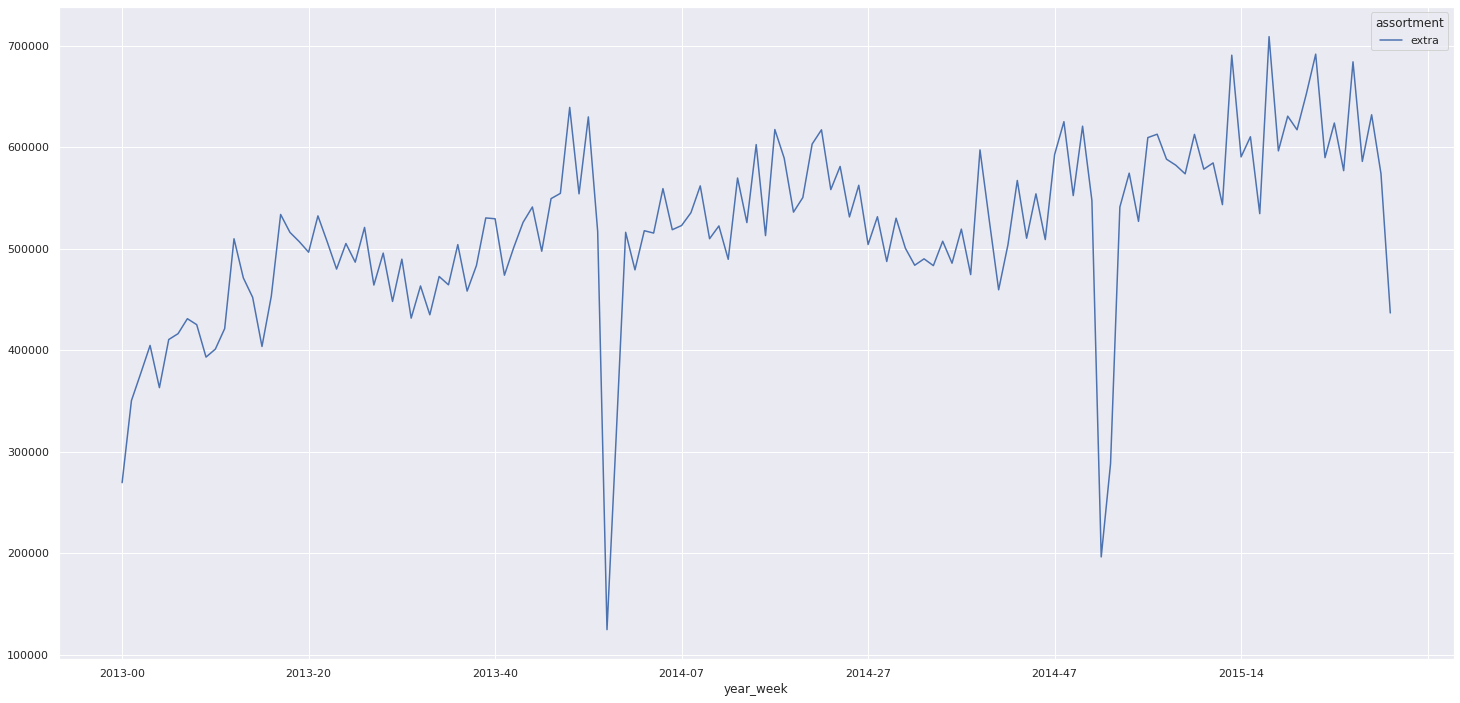

In [34]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data = aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index= 'year_week',columns= 'assortment',values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index= 'year_week',columns= 'assortment',values='sales').plot()


### H2. Stores with closer competitors should sell less - FALSE



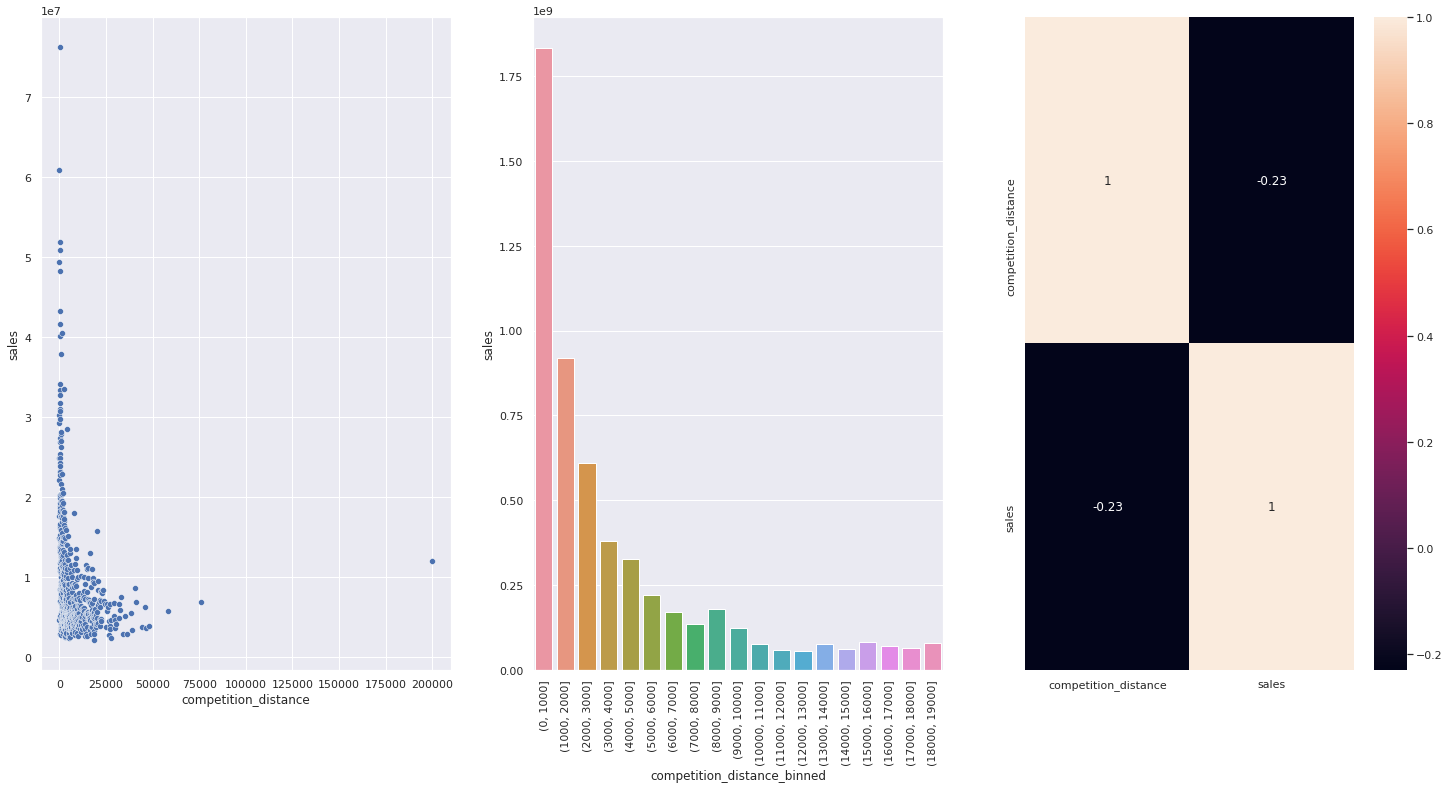

In [35]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [36]:
aux1

,competition_distance,sales,competition_distance_binned
0,20.0,4579807,"(0.0, 1000.0]"
1,30.0,17552666,"(0.0, 1000.0]"
2,40.0,29261626,"(0.0, 1000.0]"
3,50.0,60835848,"(0.0, 1000.0]"
4,60.0,22088359,"(0.0, 1000.0]"
5,70.0,30177156,"(0.0, 1000.0]"
6,80.0,14892099,"(0.0, 1000.0]"
7,90.0,49417211,"(0.0, 1000.0]"
8,100.0,24829560,"(0.0, 1000.0]"
9,110.0,31718444,"(0.0, 1000.0]"


### H3. Stores with competitors for longer should sell more - FALSE

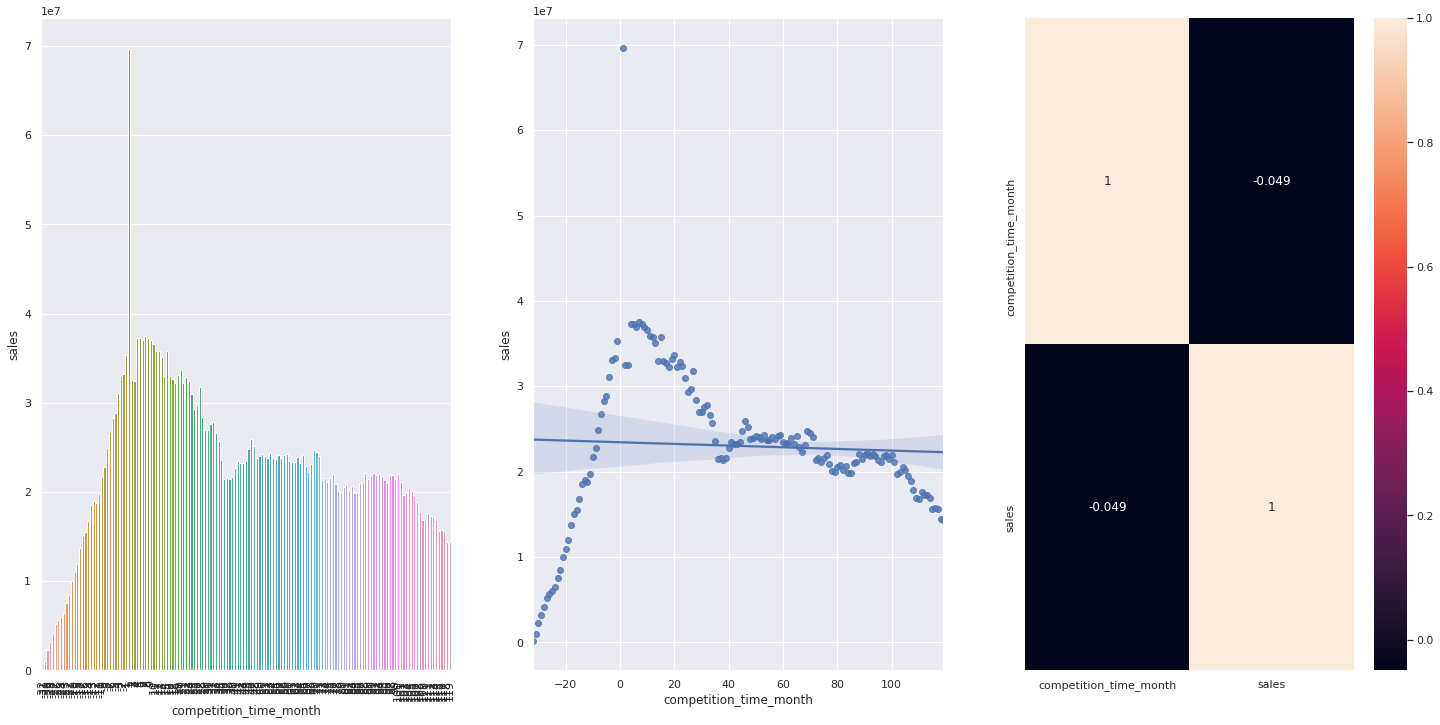

In [37]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month',y='sales',data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);


### H4. Stores with promotions active for longer should sell more - FALSE

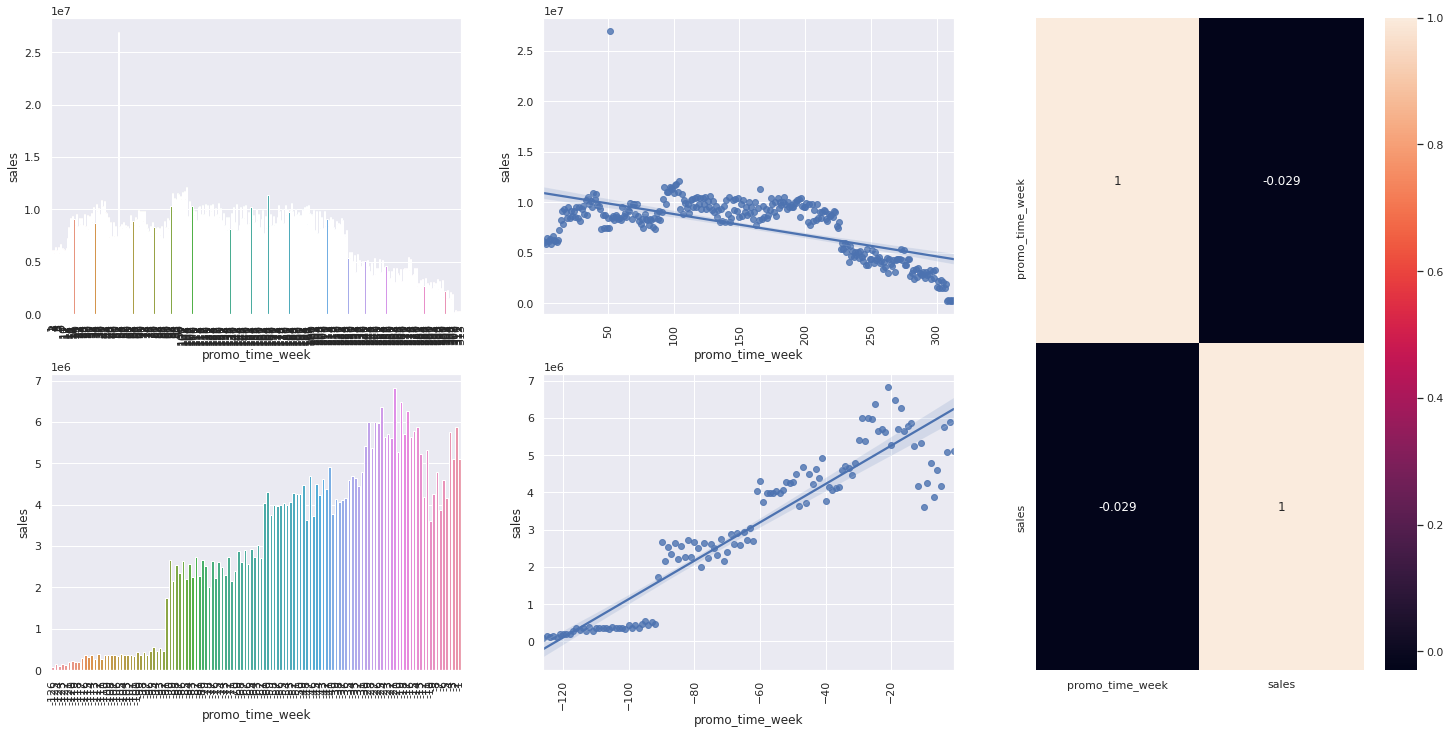

In [38]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

aux2 = aux1[aux1['promo_time_week'] > 0]
plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

aux3 = aux1[aux1['promo_time_week'] < 0]
plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr(method='pearson'),annot=True);

### <s>H5. Stores with more days of promotions should sell more </s>


### H6. Stores with more than consecutive promotions should sell more - FALSE

In [39]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


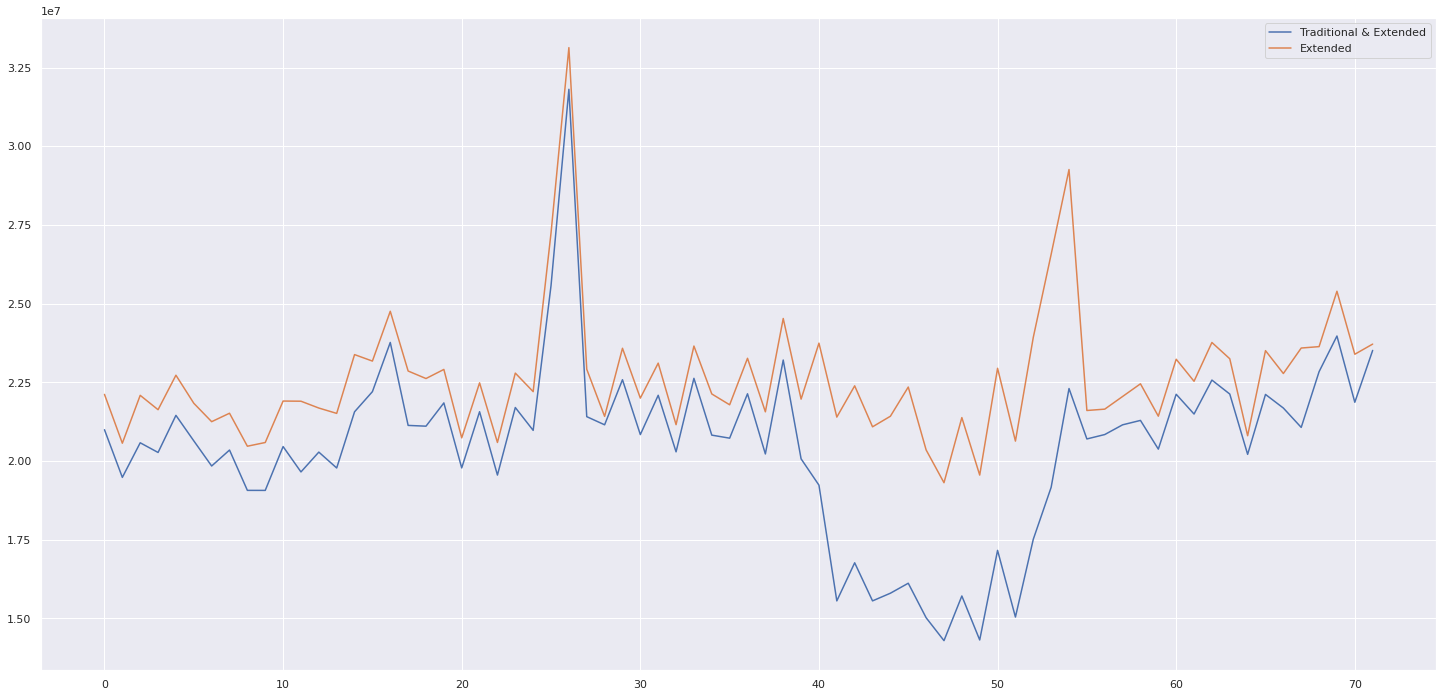

In [40]:
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1 )][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0 )][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend( labels=['Traditional & Extended', 'Extended']);

### H7. Stores open during the Christmas holiday should sell more - FALSE

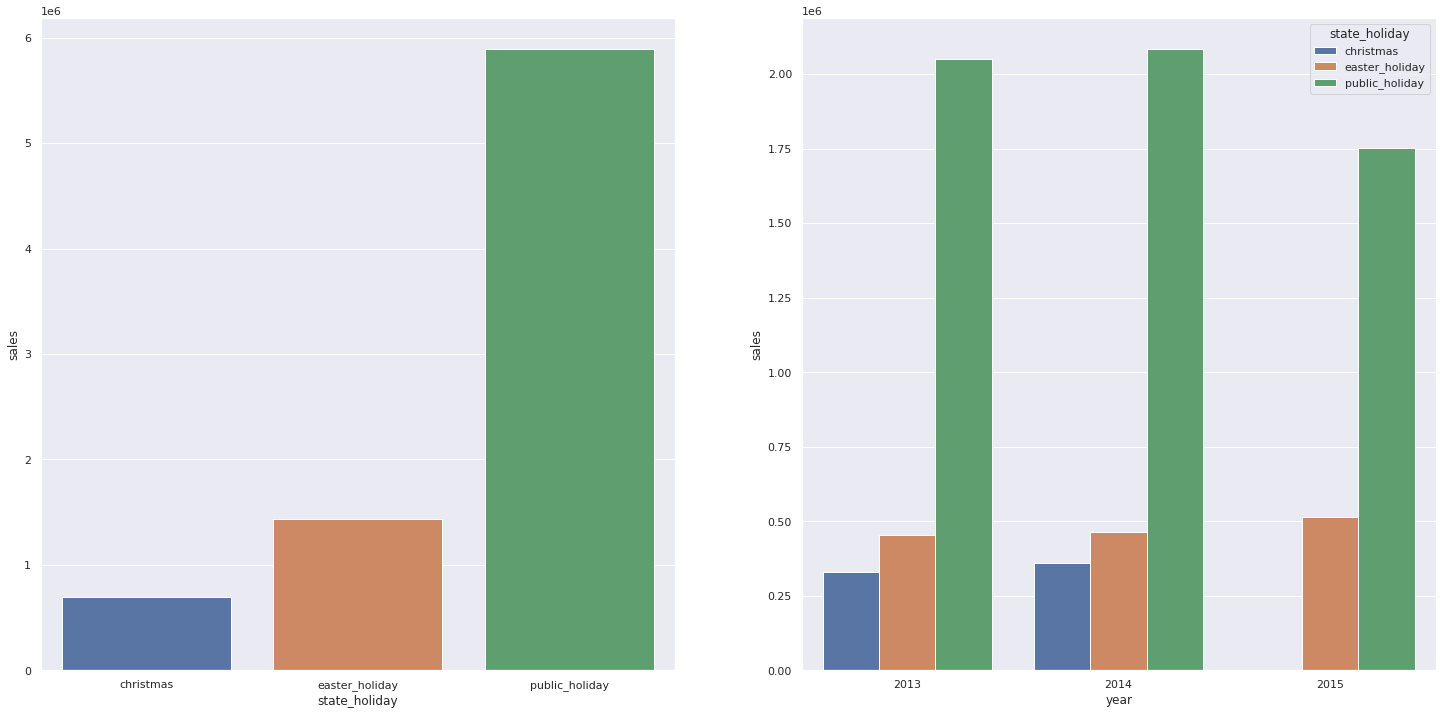

In [45]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='state_holiday' , y='sales', data= aux1);

aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()

plt.subplot(1,2,2)
sns.barplot(x='year' , y='sales', hue='state_holiday' ,data= aux2);

### H8. Stores should sell more over the years - FALSE

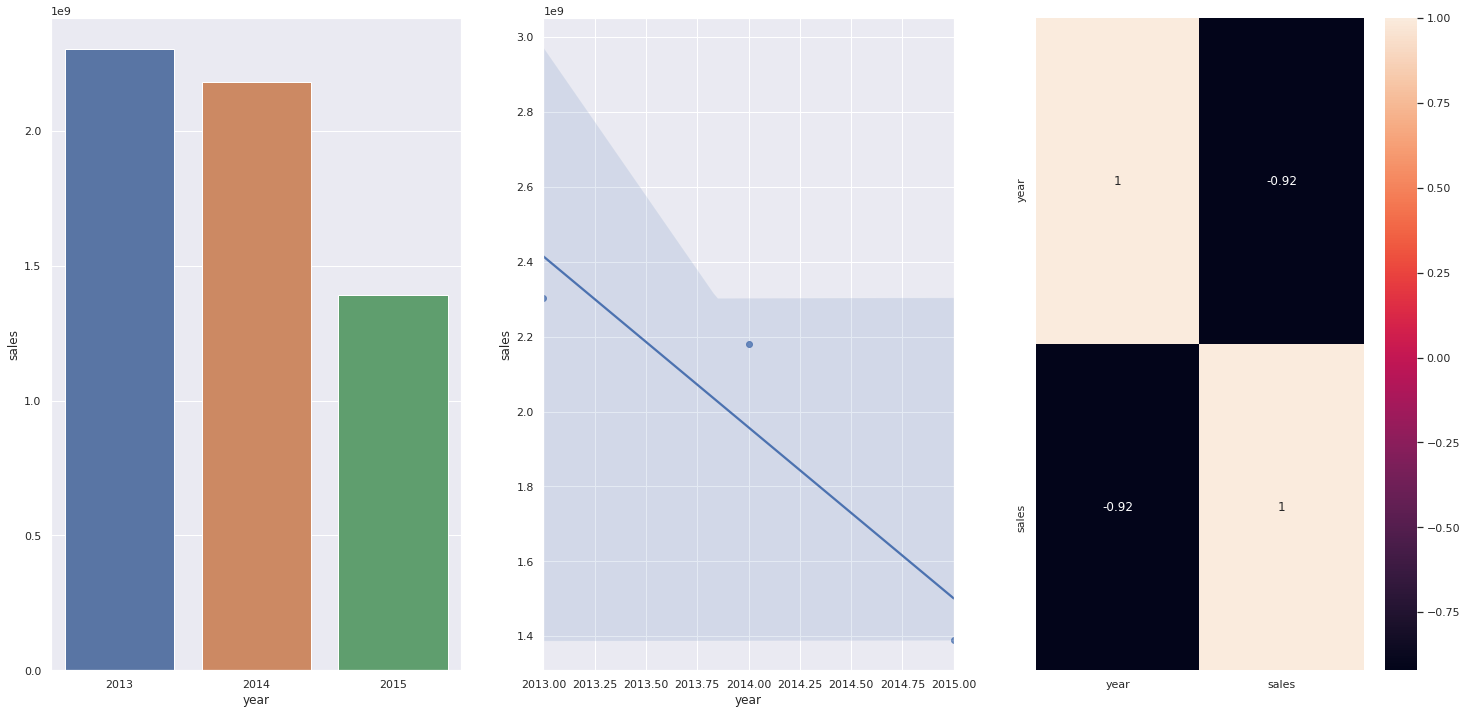

In [47]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year' , y='sales' , data=aux1 );

plt.subplot(1,3,2)
sns.regplot(x='year' , y='sales' , data=aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

### H9. Stores should sell more in the second half of the year - FALSE

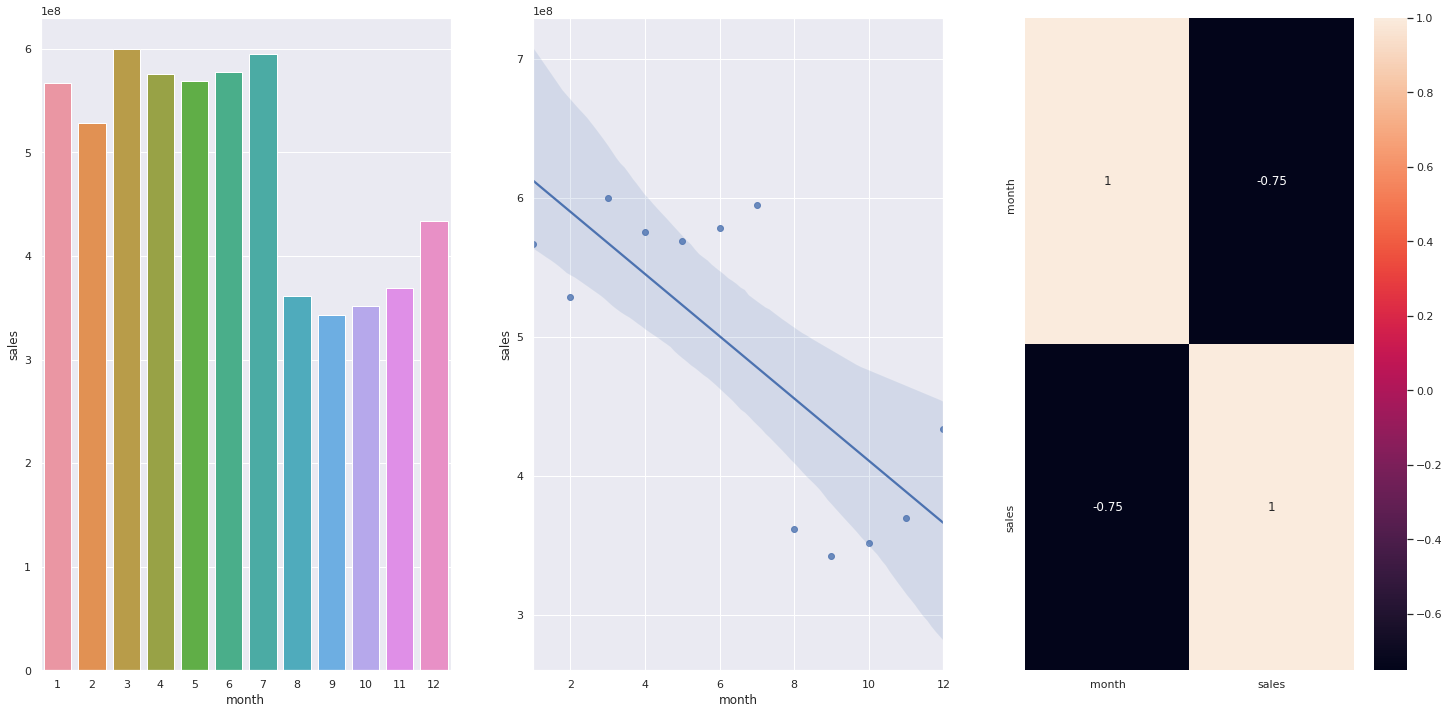

In [49]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month' , y='sales' , data=aux1 );

plt.subplot(1,3,2)
sns.regplot(x='month' , y='sales' , data=aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

### H10. Stores should sell more after the 10th of each month - TRUE

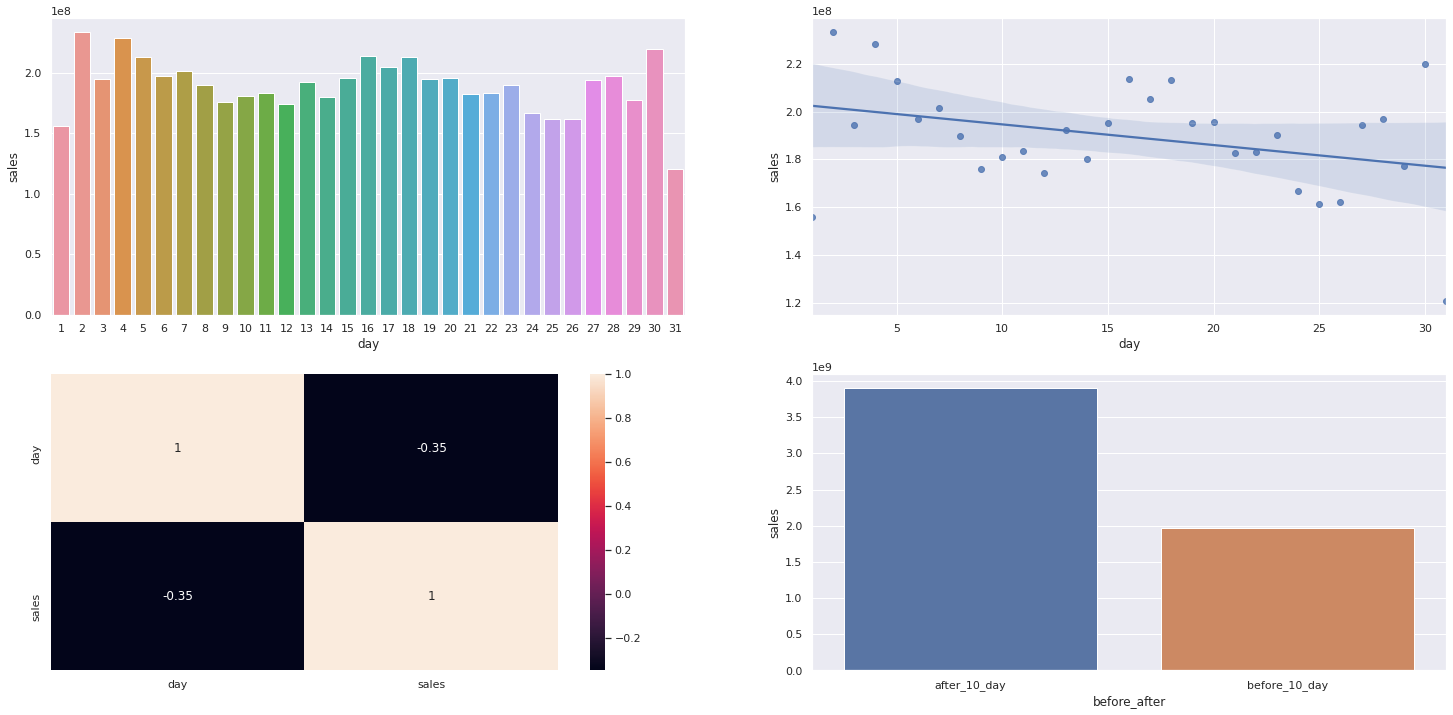

In [52]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day' , y='sales' , data=aux1 );

plt.subplot(2,2,2)
sns.regplot(x='day' , y='sales' , data=aux1 );

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_day' if x <= 10 else 'after_10_day')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after' , y='sales' , data=aux2);

### H11. Stores should sell less on weekends - TRUE

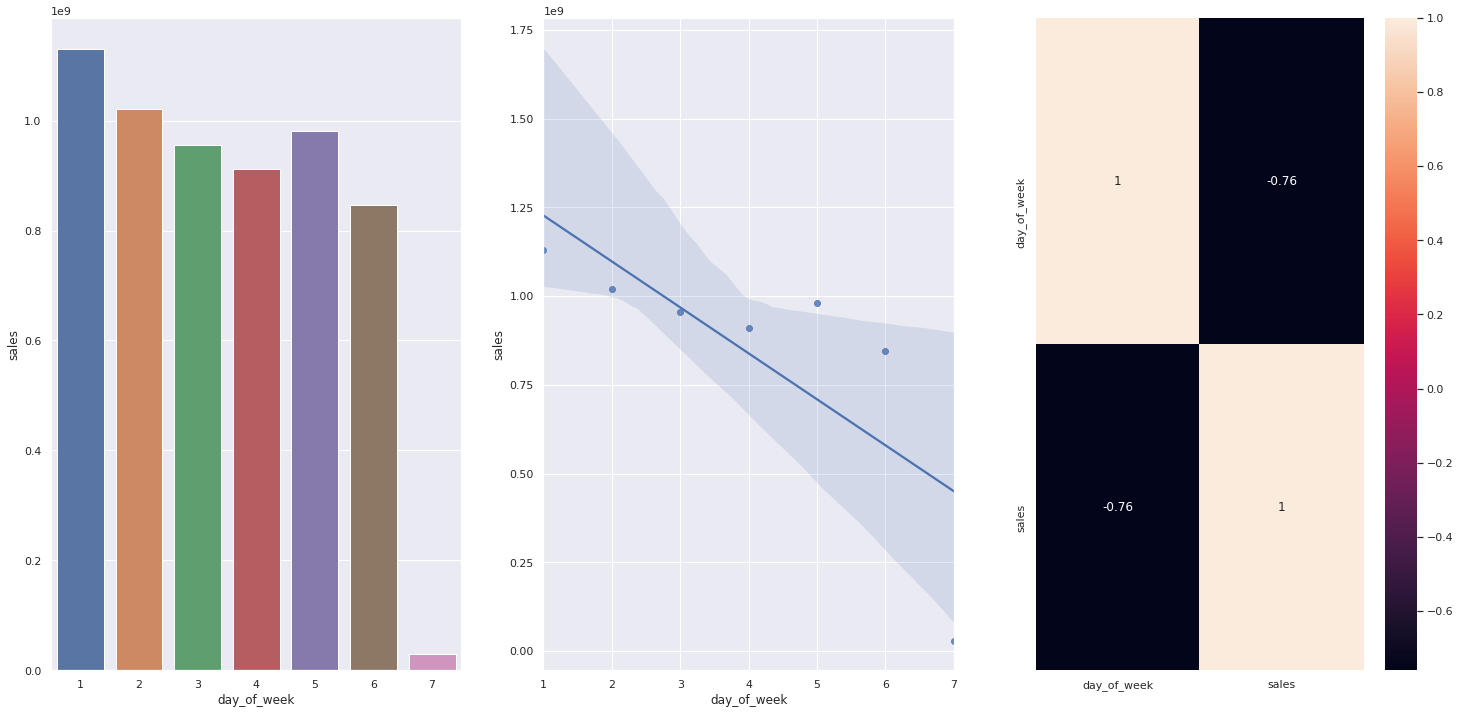

In [53]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week' , y='sales' , data=aux1 );

plt.subplot(1,3,2)
sns.regplot(x='day_of_week' , y='sales' , data=aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

### H12. Stores should sell less during school holidays - TRUE, EXCEPT JULY AND AUGUST

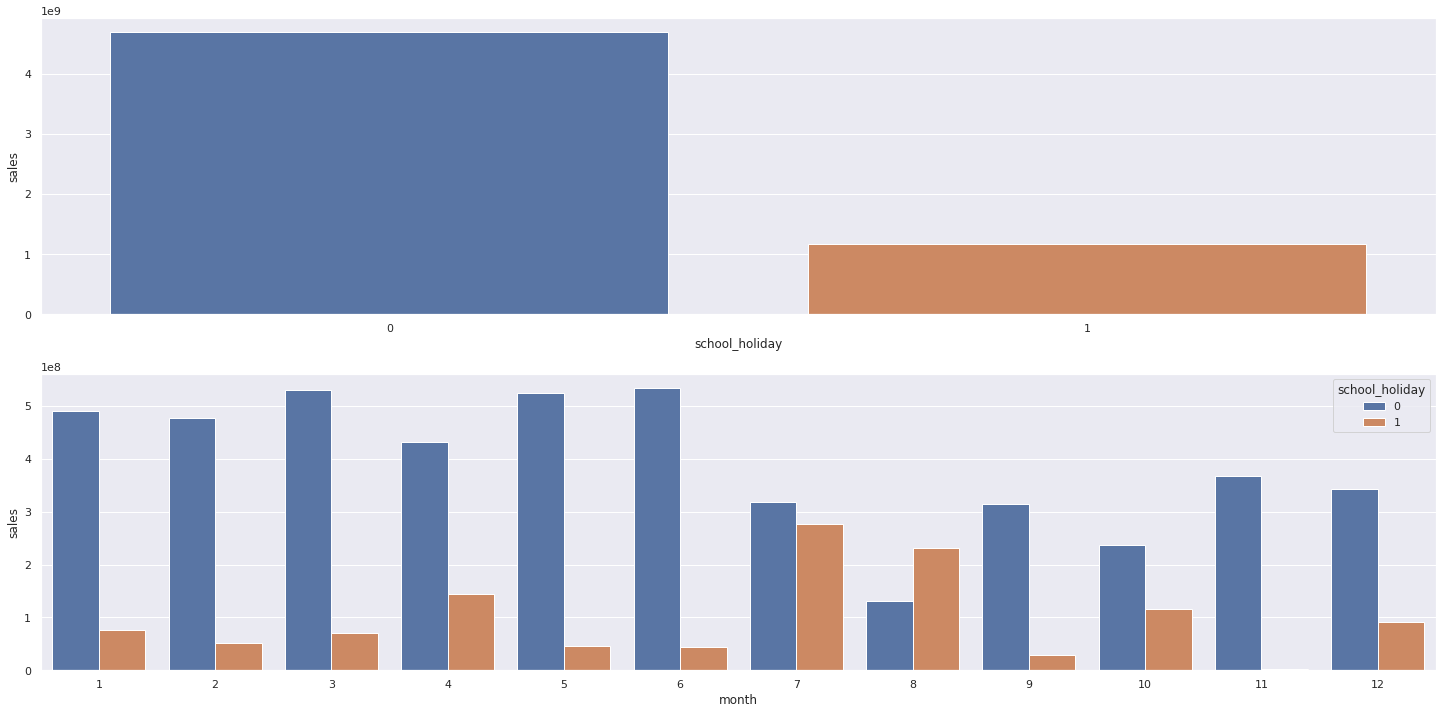

In [57]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday' , y='sales' , data=aux1 );

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month' , y='sales' , hue='school_holiday', data=aux2 );

## 4.1 Multivariate Analysis
